In [1]:
import numpy as np
import os
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from target import Target
from retrieval import Retrieval
from parameters import Parameters
import figures as figs

def init_retrieval(brown_dwarf='2M0355',PT_type='PTgrad',chem='freechem',
                   Nlive=400,tol=0.5,cloud_mode='gray',GP=True):

    brown_dwarf = Target(brown_dwarf)
    output=f'{chem}_{PT_type}_N{Nlive}_ev{tol}' # output folder name

    constant_params={} # add if needed
    free_params = {'rv': ([2,20],r'$v_{\rm rad}$'),
                'vsini': ([0,40],r'$v$ sin$i$'),
                'log_g':([3,5],r'log $g$'),
                'epsilon_limb': [(0.2,1), r'$\epsilon_\mathrm{limb}$']} # limb-darkening coefficient (0-1)

    if PT_type=='PTknot':
        pt_params={'T0' : ([1000,4000], r'$T_0$'), # bottom of the atmosphere (hotter)
                'T1' : ([0,4000], r'$T_1$'),
                'T2' : ([0,4000], r'$T_2$'),
                'T3' : ([0,4000], r'$T_3$'),
                'T4' : ([0,4000], r'$T_4$'),} # top of atmosphere (cooler)
        free_params.update(pt_params)

    if PT_type=='PTgrad':
        pt_params={'dlnT_dlnP_0': ([0.,0.4], r'$\nabla T_0$'), # gradient at T0 
                'dlnT_dlnP_1': ([0.,0.4], r'$\nabla T_1$'), 
                'dlnT_dlnP_2': ([0.,0.4], r'$\nabla T_2$'), 
                'dlnT_dlnP_3': ([0.,0.4], r'$\nabla T_3$'), 
                'dlnT_dlnP_4': ([0.,0.4], r'$\nabla T_4$'), 
                'T0': ([1000,4000], r'$T_0$')} # at bottom of atmosphere
        free_params.update(pt_params)

    # if equilibrium chemistry, define [Fe/H], C/O, and isotopologue ratios
    if chem=='equchem':
        chemistry={'C/O':([0,1], r'C/O'), 
                'Fe/H': ([-1.5,1.5], r'[Fe/H]'), 
                'log_C12_13_ratio': ([1,12], r'log $\mathrm{^{12}C/^{13}C}$'), 
                'log_O16_18_ratio': ([1,12], r'log $\mathrm{^{16}O/^{18}O}$'), 
                'log_O16_17_ratio': ([1,12], r'log $\mathrm{^{16}O/^{17}O}$')}
            
    if chem=='quequchem': # quenched equilibrium chemistry
        chemistry={'C/O':([0,1], r'C/O'), 
                'Fe/H': ([-1.5,1.5], r'[Fe/H]'), 
                'log_C12_13_ratio': ([1,12], r'log $\mathrm{^{12}C/^{13}C}$'), 
                'log_O16_18_ratio': ([1,12], r'log $\mathrm{^{16}O/^{18}O}$'), 
                'log_O16_17_ratio': ([1,12], r'log $\mathrm{^{16}O/^{17}O}$'),
                'log_Pqu_CO_CH4': ([-6,2], r'log P$_{qu}$(CO,CH$_4$,H$_2$O)'),
                'log_Pqu_NH3': ([-6,2], r'log P$_{qu}$(NH$_3$)'),
                'log_Pqu_HCN': ([-6,2], r'log P$_{qu}$(HCN)')}  
        
    # if free chemistry, define VMRs
    if chem=='freechem': 
        chemistry={'log_H2O':([-12,-1],r'log H$_2$O'),
                'log_12CO':([-12,-1],r'log $^{12}$CO'),
                'log_13CO':([-12,-1],r'log $^{13}$CO'),
                'log_C18O':([-12,-1],r'log C$^{18}$O'),
                'log_C17O':([-12,-1],r'log C$^{17}$O'),
                'log_CH4':([-12,-1],r'log CH$_4$'),
                'log_NH3':([-12,-1],r'log NH$_3$'),
                'log_HCN':([-12,-1],r'log HCN'),
                'log_HF':([-12,-1],r'log HF'),
                'log_H2(18)O':([-12,-1],r'log H$_2^{18}$O'),
                'log_H2S':([-12,-1],r'log H$_2$S')}
        
    if cloud_mode=='gray':
        cloud_props={'log_opa_base_gray': ([-10,3], r'log $\kappa_{\mathrm{cl},0}$'),  
                    'log_P_base_gray': ([-6,3], r'log $P_{\mathrm{cl},0}$'), # pressure of gray cloud deck
                    'fsed_gray': ([0,20], r'$f_\mathrm{sed}$')} # sedimentation parameter for particles
        free_params.update(cloud_props)

    if cloud_mode=='MgSiO3':
        cloud_props={'fsed': ([0,20], r'$f_\mathrm{sed}$'), # sedimentation parameter for particles
                    'sigma_lnorm': ([0.8,1.5], r'$\sigma_{l,norm}$'), # width of the log-normal particle distribution
                    'log_Kzz':([5,15],r'log $K_{zz}$')} # eddy diffusion parameter (atmospheric mixing)
        free_params.update(cloud_props)
        
    if GP==True: # add uncertainty scaling
        GP_params={'log_a': ([-1,1], r'$\log\ a$'), # one is enough, will be multipled with order/det error
                'log_l': ([-3,0], r'$\log\ l$')}
        free_params.update(GP_params)

    free_params.update(chemistry)
    parameters = Parameters(free_params, constant_params)
    cube = np.random.rand(parameters.n_params)
    parameters(cube)

    retrieval=Retrieval(target=brown_dwarf,parameters=parameters,
                    output_name=output,chemistry=chem,PT_type=PT_type)
    return retrieval

#retrieval=init_retrieval(brown_dwarf='2M1425',PT_type='PTgrad',chem='freechem',Nlive=300,tol=0.5)
retrieval=init_retrieval(brown_dwarf='2M1425',PT_type='PTgrad',chem='freechem',Nlive=400,tol=0.5)
#retrieval.PMN_lnL()
#only_params=['rv','vsini','log_g','T0','log_H2O','log_12CO','log_13CO','log_HF','log_H2(18)O','log_H2S']
#retrieval.evaluate(only_params=only_params,split_corner=False)
retrieval.evaluate(makefigs=False)

#retrieval2=init_retrieval(brown_dwarf='2M0355',PT_type='PTgrad',chem='equchem',Nlive=50,tol=10.0)

#retrieval2.evaluate(makefigs=False)
#figs.VMR_plot(retrieval,retrieval_object2=retrieval2)

/home/natalie/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/natalie/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  analysing data from /home/natalie/Desktop/files/uni/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/2M1425/freechem_PTgrad_N400_ev0.5/pmn_.txt


In [2]:
figs.plot_spectrum_split(retrieval,overplot_species=['Na_allard','Ca'])

/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


/home/natalie/Desktop/files/uni/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/figures.py:160: RuntimeWarning: Mean of empty slice
  errmean=np.nanmean(retrieval.data_err[order,det]*retrieval.final_params['s2_ij'][order,det])
/home/natalie/Desktop/files/uni/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/figures.py:182: RuntimeWarning: All-NaN slice encountered
  ymax=np.nanmax(residuals[order])
/home/natalie/Desktop/files/uni/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/figures.py:183: RuntimeWarning: All-NaN slice encountered
  ymin=np.nanmin(residuals[order])


# Overplot Na, Ca onto residuals on 2M1455

In [2]:
import numpy as np
import os
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from petitRADTRANS import Radtrans

pressure = np.logspace(-6,2,50)

K2166=np.array([[[1921.318,1934.583], [1935.543,1948.213], [1949.097,1961.128]],
                            [[1989.978,2003.709], [2004.701,2017.816], [2018.708,2031.165]],
                            [[2063.711,2077.942], [2078.967,2092.559], [2093.479,2106.392]],
                            [[2143.087,2157.855], [2158.914,2173.020], [2173.983,2187.386]],
                            [[2228.786,2244.133], [2245.229,2259.888], [2260.904,2274.835]],
                            [[2321.596,2337.568], [2338.704,2353.961], [2355.035,2369.534]],
                            [[2422.415,2439.061], [2440.243,2456.145], [2457.275,2472.388]]])

check_species=['Na_allard','Ca']
opacities={}
for spec in check_species:
    opa_orders=[]
    wave_orders=[]
    for order in range(7):
        wl_pad=0#7 # wavelength padding because spectrum is not wavelength shifted yet
        wlmin=np.min(K2166[order])-wl_pad
        wlmax=np.max(K2166[order])+wl_pad
        wlen_range=np.array([wlmin,wlmax])*1e-3 # nm to microns
        atm = Radtrans(line_species=[spec],
                            rayleigh_species = [],
                            continuum_opacities = [],
                            wlen_bords_micron=wlen_range, 
                            mode='lbl',
                            lbl_opacity_sampling=3) # take every nth point (=3 in deRegt+2024)
        
        #atm.setup_opa_structure(pressure)
        T = np.array([1400]).reshape(1)
        wave_cm, opas = atm.get_opa(T)
        wave_orders.append(wave_cm*1e7)
        opa_orders.append(opas[spec].flatten())
    opacities[spec]=opa_orders

/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


In [4]:
figs.plot_spectrum_inset(retrieval)
figs.plot_spectrum_split(retrieval)

/home/natalie/Desktop/files/uni/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/figures.py:130: RuntimeWarning: Mean of empty slice
  errmean=np.nanmean(retrieval.data_err[order,det]*retrieval.final_params['s2_ij'][order,det])


In [2]:
figs.opacity_plot(retrieval)

/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "



  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [31]:
retrieval.final_params['s2_ij']

array([[ 1.        ,  1.        ,  1.        ],
       [28.10455262, 23.71098662, 21.25306163],
       [24.71326893, 27.01109622, 25.93692154],
       [26.42409016, 25.18476372, 27.55482491],
       [30.84927881, 28.9770566 , 30.47385497],
       [36.80111073, 33.11831297, 33.38702767],
       [38.36103076, 44.13763804, 41.39298976]])

In [2]:
from petitRADTRANS import Radtrans

retrieval_object=retrieval
#def opacity_plot(retrieval_object):
Kband=retrieval_object.target.K2166
molecules=['H2O_pokazatel_main_iso','H2O_181_HotWat78','CO_main_iso','CO_36','HF_main_iso','H2S_ExoMol_main_iso']
names=['H2O','H2(18)O','12CO','13CO','HF','H2S']
labels=['H$_2^{16}$O','H$_2^{18}$O','$^{12}$CO','$^{13}$CO','HF','H$_2$S']
#molecules=['CO_main_iso']
#labels=['$^{12}$CO']

wlen_range=np.array([np.min(Kband),np.max(Kband)])*1e-3 # nm to microns
atmosphere = Radtrans(line_species=molecules,
                    rayleigh_species = ['H2', 'He'],
                    continuum_opacities = ['H2-H2', 'H2-He'],
                    wlen_bords_micron=wlen_range, 
                    mode='lbl',
                    lbl_opacity_sampling=10)

/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "



  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [3]:
import pickle
import pathlib
path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/2M1425/freechem_PTgrad_N300_ev0.5/final_params_dict.pickle')
with open(path,'rb') as file:
    final_params=pickle.load(file)

H2O 0.0005829775108180283
H2(18)O 3.1833895191825543e-15
12CO 0.0013980775710322423
13CO 1.4307311540885854e-05
HF 4.4996502855390994e-08
H2S 3.4429425921177646e-09


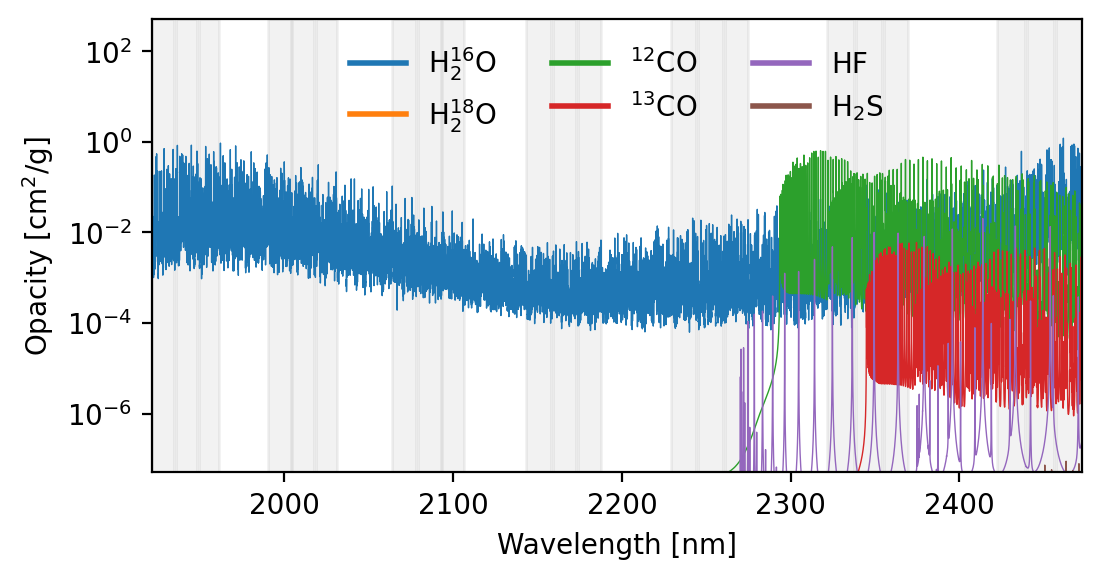

In [20]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

T = np.array([1400]).reshape(1)
wave_cm, opas = atmosphere.get_opa(T)
wave_nm = wave_cm*1e7
ymin,ymax=5e-8,5e2

fig,ax=plt.subplots(1,1,figsize=(6,3),dpi=200)
lines=[]
for i,m in enumerate(molecules):
    abund=10**final_params[f'log_{names[i]}']
    print(names[i],abund)
    spec,=plt.plot(wave_nm,opas[m]*abund,lw=0.5)
    lines.append(Line2D([0],[0],color=spec.get_color(),
                    linewidth=2,label=labels[i]))
    
for order in range(7):
    for det in range(3):
        plt.fill_betweenx([ymin,ymax],Kband[order,det][0],Kband[order,det][1],color='k',alpha=0.05)
plt.yscale('log')
plt.ylabel('Opacity [cm$^2$/g]')
plt.xlabel("Wavelength [nm]")
plt.xlim(np.min(retrieval.target.K2166),np.max(retrieval.target.K2166))
plt.ylim(ymin,ymax)
legend=plt.legend(handles=lines,ncol=3,loc='upper center')
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))
legend.get_frame().set_edgecolor((0, 0, 0, 0))


# Correlated noise correctly implemented in test spectrum??

Text(0.5, 0, 'Wavelength [nm]')

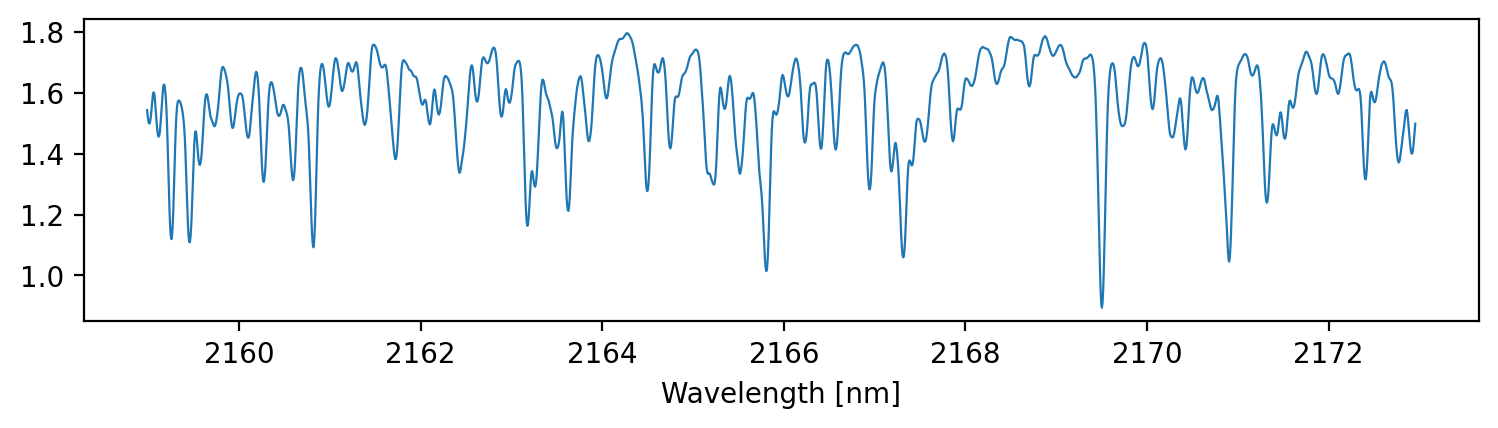

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from target import Target

wl,fl,err=Target('test').load_spectrum()
wlc,flc,errc=Target(f'test_corr').load_spectrum()

ord=3
det=1
fig,ax=plt.subplots(1,1,figsize=(9,2),dpi=200)
ax.plot(wl[ord,det],fl[ord,det],lw=0.8)
#ax.plot(wlc[ord],flc[ord],label='corr',alpha=0.5,lw=0.8)
ax.set_xlabel('Wavelength [nm]')

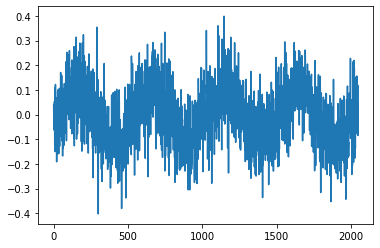

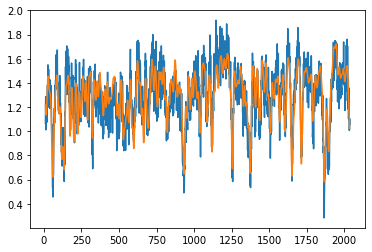

In [59]:
test=Target('test')
wl,fl,err=test.load_spectrum()

white_noise=np.random.normal(np.zeros_like(fl),0.1,size=fl.shape)
fl_GP=np.copy(fl)
err_GP=np.full(shape=fl.shape,fill_value=np.nan)

for i in range(7):
    for j in range(3):
        w=wl[i,j]
        err_corr=0.1*np.sin((w-np.nanmean(w))*2)
        err_new=white_noise[i,j]+err_corr
        err_GP[i,j]=err_new
        fl_GP[i,j]+=err_new

plt.plot(err_GP[2,2])
plt.show()
plt.plot(fl_GP[2,2])
plt.plot(fl[2,2])



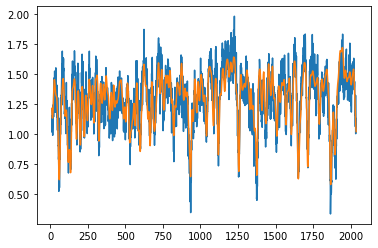

In [60]:
test=Target('test')
wl,fl,err=test.load_spectrum()
test_corr=Target('test_corr')
wlc,flc,errc=test_corr.load_spectrum()

plt.plot(flc[2,2])
plt.plot(fl[2,2])


In [52]:

np.nanmax(err)

0.0006305149720718885

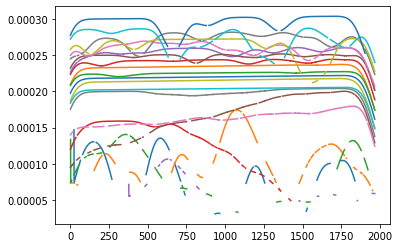

In [54]:
from covariance import *

def add_RBF_kernel(cov, a, l, separation, variance, trunc_dist=5):
      w_ij = (separation < trunc_dist*l) # Hann window function to ensure sparsity
      GP_amp = a**2 # GP amplitude
      GP_amp *= variance**2
      cov[w_ij] += GP_amp * np.exp(-(separation[w_ij])**2/(2*l**2)) # Gaussian radial-basis function kernel
      return cov

test=Target('test')
wl,fl,err=test.load_spectrum()
mask_isfinite=test.get_mask_isfinite() # mask nans, shape (orders,detectors)
separation,err_eff=test.prepare_for_covariance()

# white noise independent of data points
#white_noise=np.random.normal(np.zeros_like(fl),err,size=fl.shape)
white_noise=np.ones_like(err)*np.nanmedian(err)

# add correlated noise
Cov = np.empty((7,3), dtype=object) # covariance matrix
fl_GP=np.copy(fl)
err_GP=np.full(shape=fl.shape,fill_value=np.nan)

log_l=-0.5
log_a=0.8

for i in range(7):
    for j in range(3):
        mask_ij = mask_isfinite[i,j] # only finite pixels
        if not mask_ij.any(): # skip empty order/detector pairs
            continue
        maxval=10**(0)*3 # 3*max value of prior of l
        Cov[i,j] = CovGauss(err=white_noise[i,j,mask_ij],separation=separation[i,j], 
                            err_eff=err_eff[i,j],max_separation=maxval)
        a = 10**log_a
        l = 10**log_l
        Cov[i,j].cov=add_RBF_kernel(Cov[i,j].cov, a, l, separation[i,j], err_eff[i,j])
        err_new=np.sqrt(Cov[i,j].cov).dot(white_noise[i,j,mask_ij])
        err_GP[i,j,mask_ij]=err_new
        fl_GP[i,j,mask_ij]+=err_new

i=0
for ord in range(7):
    for det in range(3): 
        #print(np.where(err_GP[ord,det]==np.nanmax(err_GP[ord,det])))    
        plt.plot(err_GP[ord,det][70:]+i*1e-5)
        i+=1


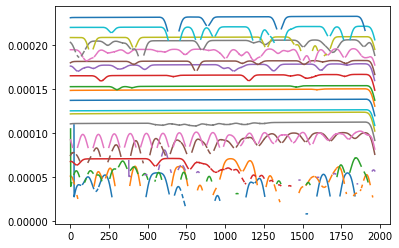

In [51]:
i=0
for ord in range(7):
    for det in range(3): 
        #print(np.where(err_GP[ord,det]==np.nanmax(err_GP[ord,det])))    
        plt.plot(err_GP[ord,det][70:]+i*1e-5)
        i+=1

In [63]:
log_l=-0.5
log_a=0.8
GP_amp=(10**log_a)**2
GP_len=(10**log_l)**2
arr=np.zeros_like(separation)
for ord in range(7):
    for det in range(3): 
        noise= GP_amp * np.exp(-(separation[ord,det])**2/(2*GP_len**2))
        arr[ord,det]=noise
i=0
for ord in range(7):
    for det in range(3): 
        #print(np.where(err_GP[ord,det]==np.nanmax(err_GP[ord,det])))    
        plt.plot(arr[ord,det][70:]+i*1e-5)
        i+=1

Error in callback <function _draw_all_if_interactive at 0x7f388081ff70> (for post_execute):


KeyboardInterrupt: 

In [8]:
import pickle
import pathlib
path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/2M1425/freechem_PTgrad_N300_ev0.5/final_params_dict.pickle')
with open(path,'rb') as file:
    final_params=pickle.load(file)
# print S/N + sigma for latex table
for molecule in ['13CO','HF','H2S','H2(18)O']:
    SNR=np.round(final_params[f'SNR_{molecule}'],decimals=2)
    sigma=np.round(final_params[f'sigma_{molecule}'],decimals=2)
    print(SNR,'\&',sigma,'\\\\')

5.11 \& 4.11 \\
4.69 \& 3.82 \\
-0.08 \& 3.49 \\
1.11 \& -1.79 \\


In [ ]:
path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/test/freechem_PTgrad_N100_ev5.0/final_params_dict.pickle')
with open(path,'rb') as file:
    final_params=pickle.load(file)
final_params#['sigma_13CO']

# Table for paper

In [6]:
import pathlib
import pickle
import numpy as np

path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/2M0355/freechem_PTgrad_N400_ev0.5/final_params_dict.pickle')
with open(path,'rb') as file:
    final_params=pickle.load(file)

path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/2M1425/freechem_PTgrad_N400_ev0.5/final_params_dict.pickle')
with open(path,'rb') as file:
    final_params2=pickle.load(file)

In [7]:
dec=3
table=["C/O &","$[$C/H$]$ &","log $^{12}$CO/$^{13}$CO &","log $^{12}$CO/C$^{17}$O &",
       "log $^{12}$CO/C$^{18}$O &","log H$_2$O/H$_2^{18}$O &"]
ratios=["C/O","C/H",'log_12CO/13CO','log_12CO/C17O','log_12CO/C18O','log_H2O/H2(18)O']

for i,r in enumerate(ratios):
      print(table[i],np.round(final_params[r][0],decimals=dec),
              "$^{+",np.round(final_params[f'{r}_err'][1][0],decimals=dec),"}_{",
              np.round(final_params[f'{r}_err'][0][0],decimals=dec),"}$ &",
              np.round(final_params2[r][0],decimals=dec),
              "$^{+",np.round(final_params2[f'{r}_err'][1][0],decimals=dec),"}_{",
              np.round(final_params2[f'{r}_err'][0][0],decimals=dec),"}$ \\\\")

C/O & 0.65 $^{+ 0.006 }_{ -0.007 }$ & 0.648 $^{+ 0.004 }_{ -0.004 }$ \\
$[$C/H$]$ & 0.547 $^{+ 0.035 }_{ -0.031 }$ & 0.363 $^{+ 0.012 }_{ -0.018 }$ \\
log $^{12}$CO/$^{13}$CO & 1.98 $^{+ 0.04 }_{ -0.038 }$ & 2.014 $^{+ 0.04 }_{ -0.038 }$ \\
log $^{12}$CO/C$^{17}$O & 6.202 $^{+ 1.559 }_{ -1.46 }$ & 6.486 $^{+ 1.318 }_{ -1.322 }$ \\
log $^{12}$CO/C$^{18}$O & 5.134 $^{+ 1.808 }_{ -1.583 }$ & 5.73 $^{+ 1.38 }_{ -1.33 }$ \\
log H$_2$O/H$_2^{18}$O & 11.5 $^{+ 0.242 }_{ -0.247 }$ & 2.7 $^{+ 3.634 }_{ -0.235 }$ \\


In [34]:
dec=2
table=["$^{13}$CO &",'HF &','H$_2$S &','H$_2^{18}$O &']
molec=['13CO','HF','H2S','H2(18)O']

for i,m in enumerate(molec):
      print(table[i],np.round(final_params[f'SNR_{m}'],decimals=dec),"&",
            np.round(final_params[f'sigma_{m}'],decimals=dec),"&",
            np.round(final_params[f'SNR_{m}'],decimals=dec),"&",
            np.round(final_params[f'sigma_{m}'],decimals=dec),"\\\\")

$^{13}$CO & 12.88 & 13.3 & 12.88 & 13.3 \\
HF & 16.5 & 11.7 & 16.5 & 11.7 \\
H$_2$S & 7.22 & 4.76 & 7.22 & 4.76 \\
log H$_2^{18}$O & 3.16 & 2.47 & 3.16 & 2.47 \\


In [8]:
dec=3

table=["$v_{\\text{rad}}$ [km/s] & Radial velocity & $\mathcal{U}$(2,20) &",
       "$v\\text{sin}i$ [km/s] & Projected rotational velocity & $\mathcal{U}$(0,40) &",
       "log $g$ [cm/s$^2$] & Surface gravity & $\mathcal{U}$(3,5) &",
       "$\epsilon_\mathrm{limb}$ & Limb-darkening coefficient & $\mathcal{U}$(0.2,1) &",
       "",
       "log H$_2$O & log$_{10}$ VMR of H$_2$O & $\mathcal{U}$(-12,-1) & ",
       "log $^{12}$CO & log$_{10}$ VMR of $^{12}$CO & $\mathcal{U}$(-12,-1) &",
       "log $^{13}$CO & log$_{10}$ VMR of $^{13}$CO & $\mathcal{U}$(-12,-1) & ",
       "log C$^{18}$O & log$_{10}$ VMR of C$^{18}$O & $\mathcal{U}$(-12,-1) &",
       "log C$^{17}$O & log$_{10}$ VMR of C$^{17}$O & $\mathcal{U}$(-12,-1) &",
       "log CH$_4$ & log$_{10}$ VMR of CH$_4$ & $\mathcal{U}$(-12,-1) &",
       "log NH$_3$ & log$_{10}$ VMR of NH$_3$ & $\mathcal{U}$(-12,-1) & ",
       "log HCN & log$_{10}$ VMR of HCN & $\mathcal{U}$(-12,-1) &",
       "log HF & log$_{10}$ VMR of HF & $\mathcal{U}$(-12,-1) & ",
       "log H$_2$S & log$_{10}$ VMR of H$_2$S & $\mathcal{U}$(-12,-1) & ",
       "log H$_2^{18}$O & log$_{10}$ VMR of H$_2^{18}$O & $\mathcal{U}$(-12,-1) &",
      "",
      "$T_0$ [K] & Temperature at $P_0=10^2\,$bar& $\mathcal{U}$(1000,4000) &",
      " $\\nabla T_0$ & Temperature gradient at $P_0=10^2\,$bar& $\mathcal{U}$(0,0.4) &",
      "$\\nabla T_1$ & Temperature gradient at $P_1=10^0\,$bar& $\mathcal{U}$(0,0.4) &",
      "$\\nabla T_2$ & Temperature gradient at $P_2=10^0\,$bar& $\mathcal{U}$(0,0.4) &",
      "$\\nabla T_3$ & Temperature gradient at $P_3=10^0\,$bar& $\mathcal{U}$(0,0.4) &",
      "$\\nabla T_4$ & Temperature gradient at $P_4=10^0\,$bar& $\mathcal{U}$(0,0.4) &",
      "",
      "log $\kappa_{\mathrm{cl},0}$ [cm$^2$/g] & Opacity at cloud base & $\mathcal{U}$(-10,3) & ",
      "log $P_{\mathrm{cl},0}$ [bar] & Cloud base pressure & $\mathcal{U}$(-6,3) &",
      "$f_\mathrm{sed}$ & Cloud decay power & $\mathcal{U}$(0,20) &",
      "",
      "log $a$ & GP amplitude & $\mathcal{U}$(-1,1) &",
      "log $l$ [nm] & GP length-scale & $\mathcal{U}$(-3,0) &"]
table_vals=['rv','vsini','log_g','epsilon_limb',"",'log_H2O',"log_12CO","log_13CO",
            "log_C18O","log_C17O","log_CH4","log_NH3","log_HCN","log_HF","log_H2S",
            "log_H2(18)O","",'T0','dlnT_dlnP_0','dlnT_dlnP_1','dlnT_dlnP_2',
            'dlnT_dlnP_3','dlnT_dlnP_4',"","log_opa_base_gray","log_P_base_gray",
            "fsed_gray","","log_a","log_l"]

if True:
      for i,tpar in enumerate(table_vals):
            if tpar=="":
                  print("\hline")
            else:
                  print(table[i],np.round(final_params[tpar],decimals=dec),
                        "$^{+",np.round(final_params[f'{tpar}_err'][1],decimals=dec),"}_{",
                        np.round(final_params[f'{tpar}_err'][0],decimals=dec),"}$ &",
                        np.round(final_params2[tpar],decimals=dec),
                        "$^{+",np.round(final_params2[f'{tpar}_err'][1],decimals=dec),"}_{",
                        np.round(final_params2[f'{tpar}_err'][0],decimals=dec),"}$ \\\\")

$v_{\text{rad}}$ [km/s] & Radial velocity & $\mathcal{U}$(2,20) & 13.251 $^{+ 0.011 }_{ -0.01 }$ & 5.47 $^{+ 0.048 }_{ -0.041 }$ \\
$v\text{sin}i$ [km/s] & Projected rotational velocity & $\mathcal{U}$(0,40) & 3.026 $^{+ 0.09 }_{ -0.086 }$ & 31.576 $^{+ 0.191 }_{ -0.183 }$ \\
log $g$ [cm/s$^2$] & Surface gravity & $\mathcal{U}$(3,5) & 4.72 $^{+ 0.038 }_{ -0.037 }$ & 4.975 $^{+ 0.012 }_{ -0.016 }$ \\
$\epsilon_\mathrm{limb}$ & Limb-darkening coefficient & $\mathcal{U}$(0.2,1) & 0.671 $^{+ 0.163 }_{ -0.194 }$ & 0.73 $^{+ 0.039 }_{ -0.04 }$ \\
\hline
log H$_2$O & log$_{10}$ VMR of H$_2$O & $\mathcal{U}$(-12,-1) &  -3.032 $^{+ 0.032 }_{ -0.031 }$ & -3.21 $^{+ 0.009 }_{ -0.015 }$ \\
log $^{12}$CO & log$_{10}$ VMR of $^{12}$CO & $\mathcal{U}$(-12,-1) & -2.768 $^{+ 0.034 }_{ -0.031 }$ & -2.953 $^{+ 0.012 }_{ -0.017 }$ \\
log $^{13}$CO & log$_{10}$ VMR of $^{13}$CO & $\mathcal{U}$(-12,-1) &  -4.747 $^{+ 0.044 }_{ -0.048 }$ & -4.967 $^{+ 0.04 }_{ -0.046 }$ \\
log C$^{18}$O & log$_{10}$ VMR of C

# Make plots for presentation

In [ ]:
import getpass
import os
import numpy as np
import matplotlib.pyplot as plt
os.environ['OMP_NUM_THREADS'] = '1' # to avoid using too many CPUs

if getpass.getuser() == "grasser": # when runnig from LEM
    os.environ['pRT_input_data_path'] ="/net/lem/data2/pRT_input_data"
    os.environ['OMP_NUM_THREADS'] = '1' # important for MPI
    from mpi4py import MPI 
    comm = MPI.COMM_WORLD # important for MPI
    rank = comm.Get_rank() # important for MPI
    from atm_retrieval.target import Target
    from atm_retrieval.likelihood import Retrieval
    from atm_retrieval.parameters import Parameters
    import matplotlib
    matplotlib.use('Agg') # disable interactive plotting
elif getpass.getuser() == "natalie": # when testing from my laptop
    os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
    from target import Target
    from likelihood import Retrieval
    from parameters import Parameters
    from pRT_model import pRT_spectrum


M0355 = Target('2M0355')
data_wave,data_flux,data_err=M0355.load_spectrum()

constant_params = {'vsini': 2, # rotational velocity
                'rv': 11.92,
                'log_Kzz': 7.5, # eddy diffusion parameter (atmospheric mixing)
                'fsed': 2, # sedimentation parameter for particles
                'P_base_gray': 1, # pressure of gray cloud deck
                'fsed_gray': 2,
                'opa_base_gray': 0.8, # opacity of gray cloud deck
                'sigma_lnorm': 1.05, # width of the log-normal particle distribution of MgSiO3
                'log_MgSiO3' : 0, # scaling wrt chem equilibrium, 0 = equilibrium abundance 
                'log_H2O': -2.9,#-2.9,
                'log_12CO': -2.67,#-2.66,
                'log_13CO':-4.9,
                'log_C18O':-12, #-8.3,
                'log_C17O':-12,  #-8.7,
                'log_CH4':-12, #-8.6,
                'log_NH3':-12, #-8.9,
                'log_HCN':-12, #-8,
                'T1' : 2500, # bottom of the atmosphere (hotter)
                'T2' : 1500,
                'T3' : 1270,
                'T4' : 313, # top of atmosphere (cooler)
                'log_g':4.95,
                } 

free_params = {}
parameters = Parameters(free_params,constant_params)
params=parameters.params


output='2M0355_test4'
retrieval=Retrieval(target=M0355,parameters=parameters,output_name=output)
atmosphere_objects=retrieval.atmosphere_objects

species=retrieval.get_species(param_dict=parameters.params)
model_flux=pRT_spectrum(parameters=params,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()


In [ ]:
params_H2O=params.copy()
params_H2O['log_12CO']=-12
params_H2O['log_13CO']=-12
H2O_flux=pRT_spectrum(parameters=params_H2O,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()

params_CO=params.copy()
params_CO['log_H2O']=-12
params_CO['log_13CO']=-12
CO_flux=pRT_spectrum(parameters=params_CO,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(7,3),dpi=200,sharex=True)
order=5
det=0
for i in range(2):
    ax[i].plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
    ax[i].set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
    ax[i].yaxis.set_visible(False) # remove ylabels because anyway unitless

ax[0].plot(data_wave[order,det],model_flux[order,det],lw=1,alpha=0.8,c='c',label='model')
ax[1].plot(data_wave[order,det],H2O_flux[order,det],lw=1,alpha=0.8,c='tab:blue',label='H$_2$O')
ax[1].plot(data_wave[order,det],CO_flux[order,det],lw=1,alpha=0.8,c='tab:orange',label='CO')

ax[0].legend(fontsize=8)
ax[1].legend(fontsize=8)
ax[1].set_xlabel('Wavelength [nm]')
fig.tight_layout(h_pad=-0.1)
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/spectrum.jpg')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(7,2),dpi=200,sharex=True)
order=5
det=0
#ax.plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
ax.set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
ax.plot(data_wave[order,det],model_flux[order,det],lw=1,alpha=0.8,c='c',label='model')
#ax.legend(fontsize=8)
ax.yaxis.set_visible(False) # remove ylabels because anyway unitless
ax.set_xlabel('Wavelength [nm]')
fig.tight_layout()
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/model.jpg')

In [ ]:
params_bad=params.copy()
params_bad['log_H2O']=-3.5
params_bad['log_CO']=-2
params_bad['vsini']=7
params_bad['T1']=1700
bad_flux=pRT_spectrum(parameters=params_bad,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()
fig,ax=plt.subplots(1,1,figsize=(7,2),dpi=200,sharex=True)
order=5
det=0
#ax.plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
ax.set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
ax.plot(data_wave[order,det],bad_flux[order,det],lw=1,alpha=1,c='c',label='model')
#ax.legend(fontsize=8)
ax.yaxis.set_visible(False) # remove ylabels because anyway unitless
ax.set_xlabel('Wavelength [nm]')
fig.tight_layout()
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/bad_model1.jpg')